In [75]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

calibration_images = glob.glob('./camera_cal/calibration*.jpg')


In [76]:
# Arrays to store object points and image points

object_points = []
image_points = []

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for fname in calibration_images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        object_points.append(objp)
        image_points.append(corners)

# calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)



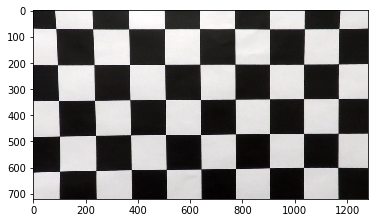

In [77]:
dst = cv2.undistort(mpimg.imread('./camera_cal/calibration1.jpg'), mtx, dist, None, mtx)
plt.imshow(dst)

In [78]:
# Define gradient threshold functions

def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    grad = np.sqrt(sobelx ** 2 + sobely ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    grad_scaled = np.uint8(255*grad/np.max(grad))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(grad_scaled)
    binary_output[(grad_scaled >= mag_thresh[0]) & (grad_scaled <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output



In [79]:
# Lane finding pipeline
def find_lanes(img, mtx=mtx, dist=dist):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    gradx_bin = abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh_min=0, thresh_max=255)
    grady_bin = abs_sobel_thresh(img, sobel_kernel=3, orient='y', thresh_min=0, thresh_max=255)
    mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255))
    dir_bin = dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3))
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    S_thresh = (90, 255)
    S_bin = np.zeros_like(S)
    S_bin[(S > S_thresh[0]) & (S <= S_thresh[1])] = 1
    
    output_img = np.zeros_like(dir_bin)
    output_img[(gradx_bin == 1) & (grady_bin == 1) & (mag_bin == 1) & (dir_bin == 1) & (S_bin == 1)] = 1
    return output_img

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


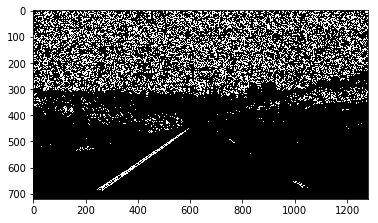

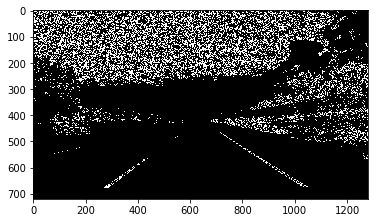

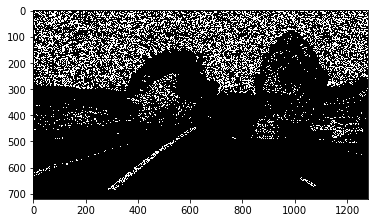

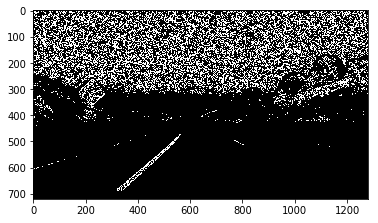

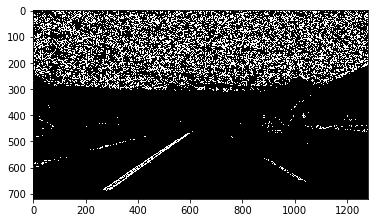

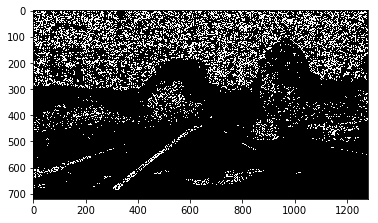

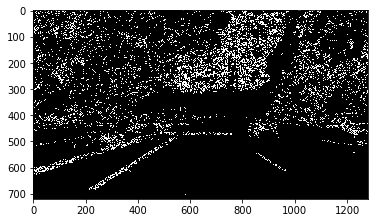

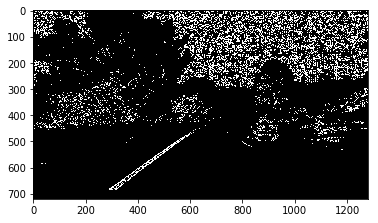

In [80]:
test_images = glob.glob('./test_images/straight_lines*.jpg') + glob.glob('./test_images/test*.jpg')
n_img = len(test_images)

for i in range(n_img):
    image = mpimg.imread(test_images[i])
    print(image.shape)
    image = find_lanes(image)
    plt.figure()
    plt.imshow(image, cmap='gray')


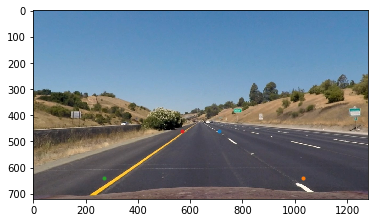

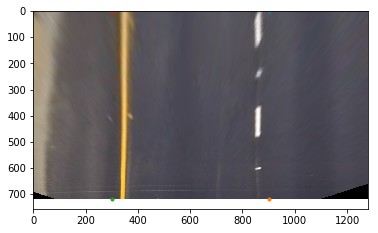

In [97]:
image = mpimg.imread(test_images[0])
image = cv2.undistort(image, mtx, dist, None, mtx)
src = np.float32(
    [[710,460],
    [1030,640],
    [270,640],
    [570,460]])
plt.figure()
plt.imshow(image)
plt.plot(src[0][0],src[0][1],'.')
plt.plot(src[1][0],src[1][1],'.')
plt.plot(src[2][0],src[2][1],'.')
plt.plot(src[3][0],src[3][1],'.')

dst = np.float32(
    [[900,0],
    [900,720],
    [300,720],
    [300,0]])

M = cv2.getPerspectiveTransform(src, dst)

warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

plt.figure()
plt.imshow(warped)
plt.plot(dst[0][0],dst[0][1],'.')
plt.plot(dst[1][0],dst[1][1],'.')
plt.plot(dst[2][0],dst[2][1],'.')
plt.plot(dst[3][0],dst[3][1],'.')